# Importing Necessary Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from PIL import Image

import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16

import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set the paths for training and testing data
train_data_dir = '/content/drive/MyDrive/MriDataset/Training'
test_data_dir = '/content/drive/MyDrive/MriDataset/Testing'

# Reading the Data

In [4]:
def generate_data_paths(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

train_data_dir = '/content/drive/MyDrive/MriDataset/Training'
test_data_dir = '/content/drive/MyDrive/MriDataset/Testing'

train_df = generate_data_paths(train_data_dir)
test_df = generate_data_paths(test_data_dir)

valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=43)


# Data Preprocessing

In [5]:
batch_size = 32
img_size = (128, 128)  # Smaller input size for faster training

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=False)


Found 5755 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# Data Exploration and Visualization
Before building the models, it's crucial to understand the dataset. This includes visualizing the distribution of classes, inspecting some images, and understanding the data characteristics.

## Visualizing the Distribution of Classes

<ipython-input-7-7ceda5c5491e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='labels', data=train_df, palette="viridis")


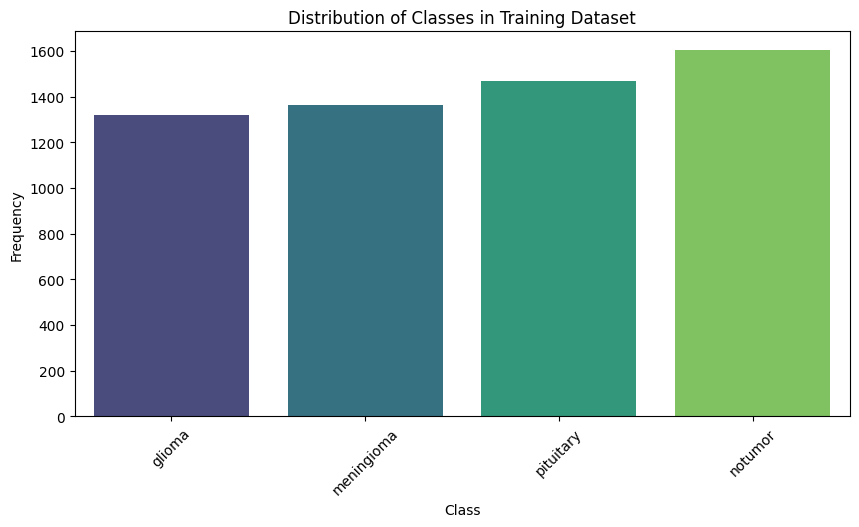

<ipython-input-7-7ceda5c5491e>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='labels', data=valid_df, palette="viridis")


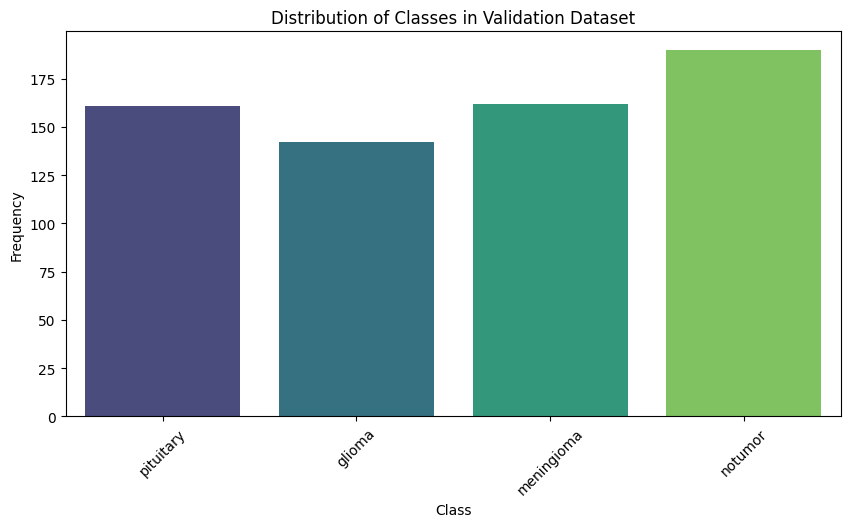

<ipython-input-7-7ceda5c5491e>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='labels', data=test_df, palette="viridis")


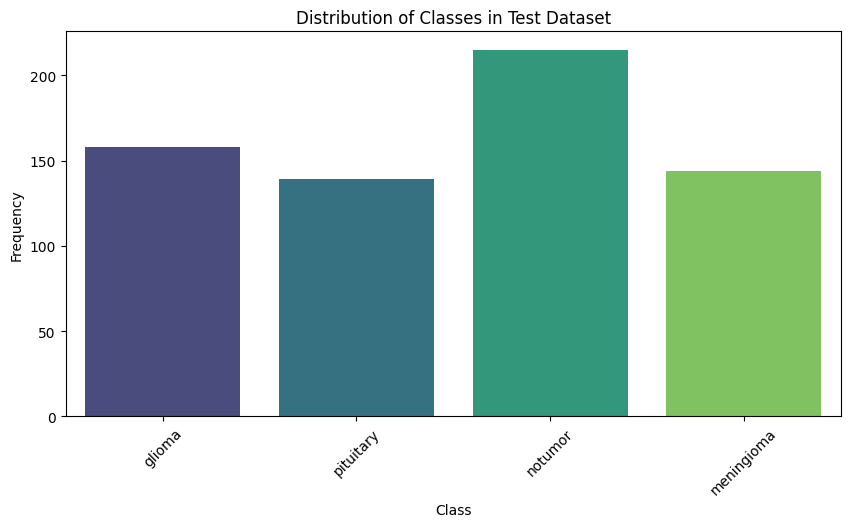

In [7]:
import seaborn as sns
# Visualizing the distribution of classes in the training dataset
plt.figure(figsize=(10, 5))
sns.countplot(x='labels', data=train_df, palette="viridis")
plt.title('Distribution of Classes in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Repeat the same for the validation and test datasets
plt.figure(figsize=(10, 5))
sns.countplot(x='labels', data=valid_df, palette="viridis")
plt.title('Distribution of Classes in Validation Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='labels', data=test_df, palette="viridis")
plt.title('Distribution of Classes in Test Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


## Inspecting Sample Images from Each Class

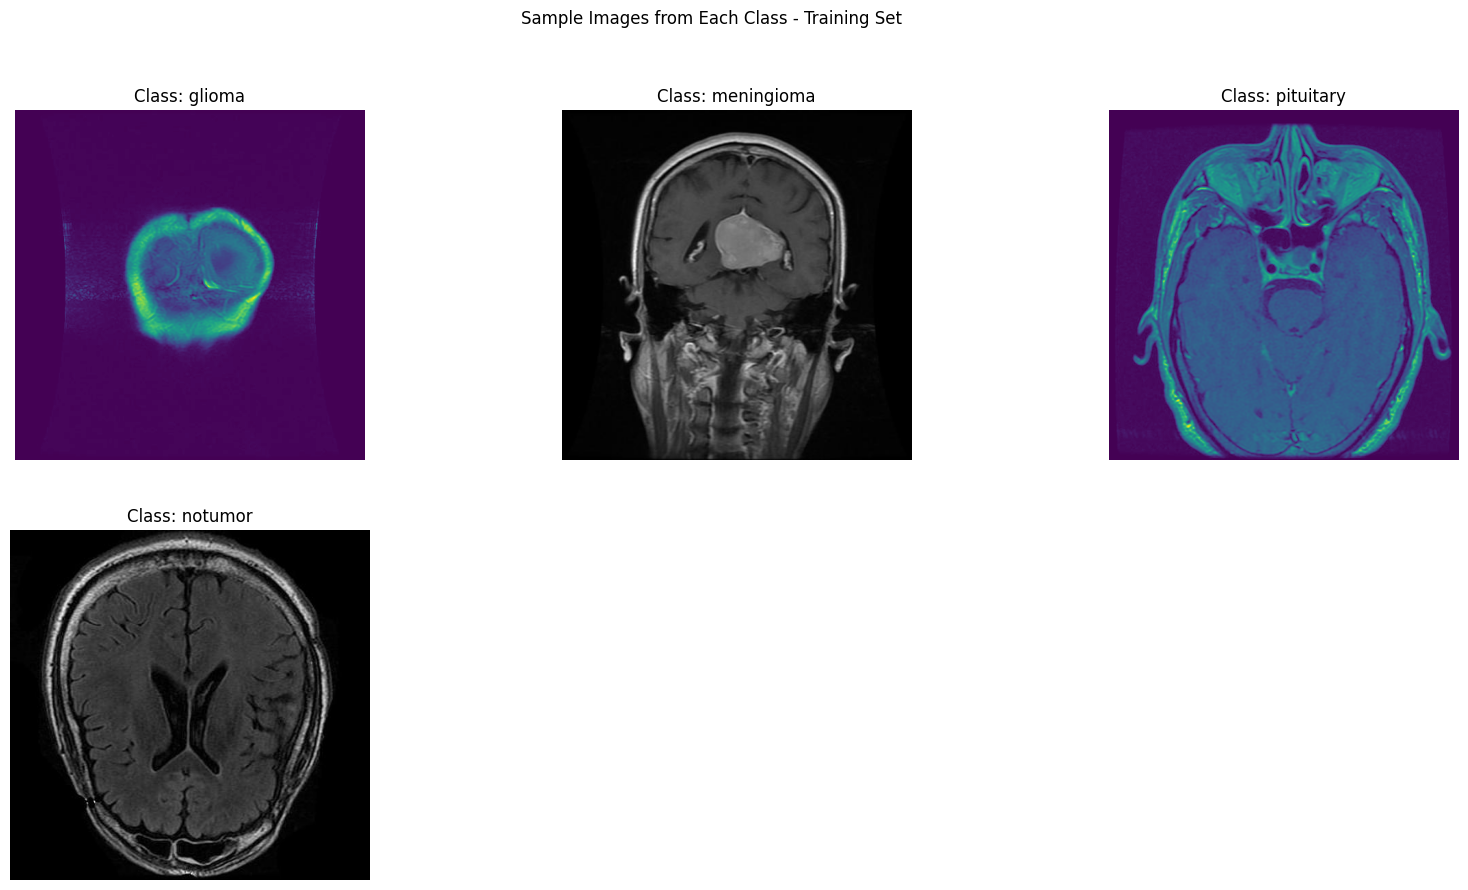

In [8]:
def plot_sample_images_by_class(df, generator, title):
    class_names = df['labels'].unique()
    plt.figure(figsize=(20, 10))
    for i, class_name in enumerate(class_names):
        sample = df[df['labels'] == class_name].sample(1).iloc[0]
        img = Image.open(sample['filepaths'])
        plt.subplot(2, len(class_names)//2 + 1, i + 1)
        plt.imshow(img)
        plt.title(f"Class: {class_name}", fontsize=12)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_sample_images_by_class(train_df, train_gen, "Sample Images from Each Class - Training Set")


## Visualizing Images After Preprocessing
This visualization step helps in understanding how the images look after resizing and normalization.

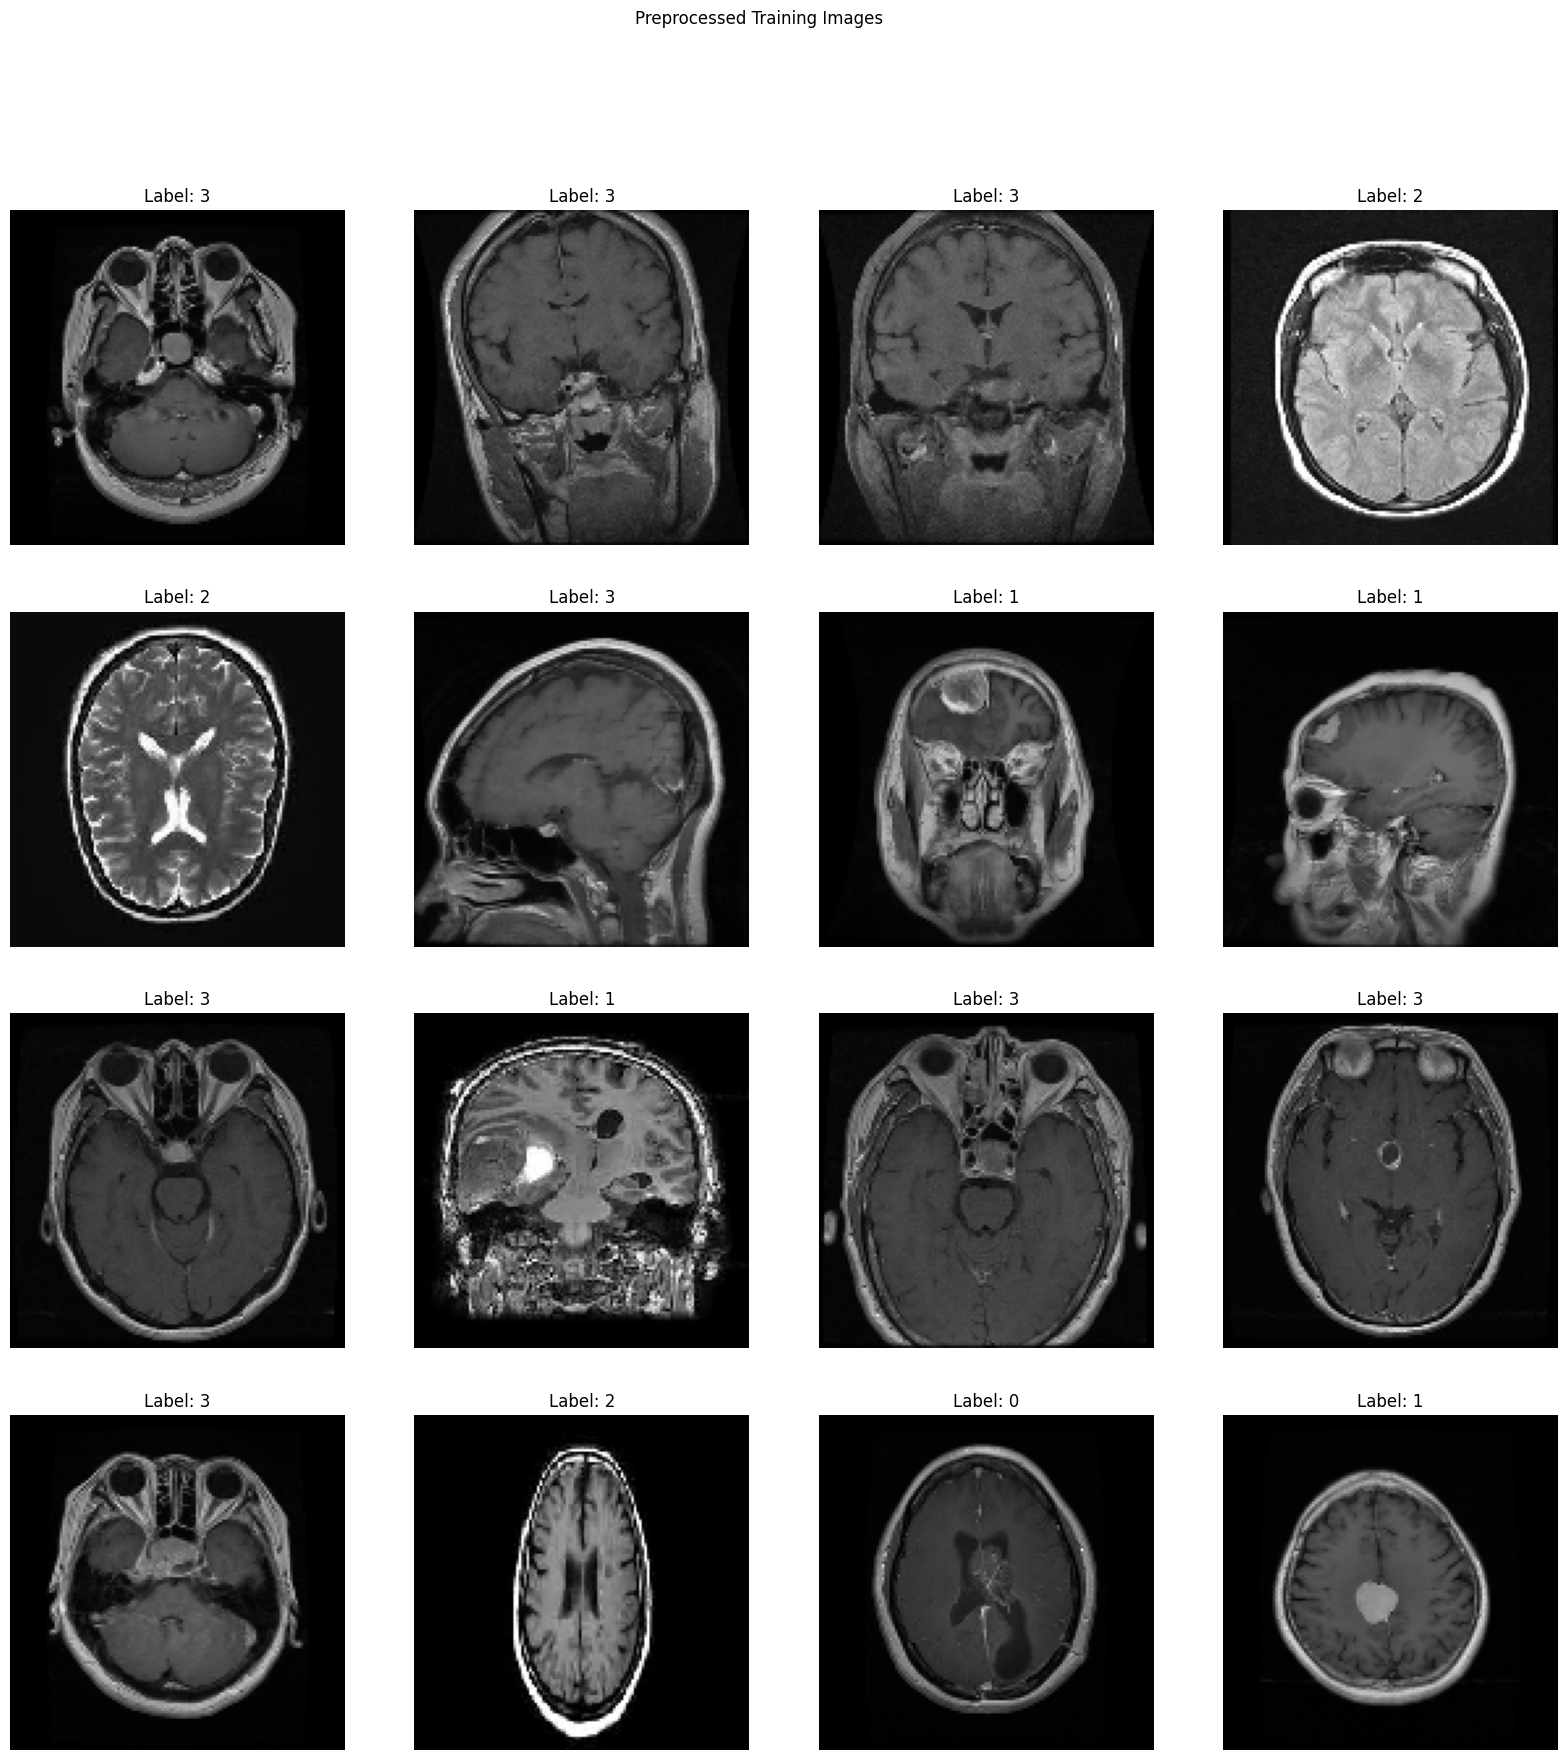

In [9]:
def plot_preprocessed_images(generator, title):
    images, labels = next(generator)
    plt.figure(figsize=(20, 20))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {np.argmax(labels[i])}", fontsize=12)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_preprocessed_images(train_gen, "Preprocessed Training Images")


# Building the Modified VGG Model

In [10]:
def build_modified_vgg(input_shape, num_classes):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (128, 128, 3)
num_classes = len(train_gen.class_indices)
vgg_model = build_modified_vgg(input_shape, num_classes)
vgg_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,270,852 (23.92 MB)

 Trainable params: 6,270,852 (23.92 MB)

 Non-trainable params: 0 (0.00 B)

# Training the Model

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_vgg = vgg_model.fit(
    train_gen,
    epochs=20,
    validation_data=valid_gen,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/180 ━━━━━━━━━━━━━━━━━━━━ 1386s 7s/step - accuracy: 0.5672 - loss: 0.9517 - val_accuracy: 0.7588 - val_loss: 0.5839
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.8411 - loss: 0.4387 - val_accuracy: 0.8672 - val_loss: 0.3637
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.8916 - loss: 0.2875 - val_accuracy: 0.8458 - val_loss: 0.4086
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.9154 - loss: 0.2244 - val_accuracy: 0.8763 - val_loss: 0.3598
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.9291 - loss: 0.1867 - val_accuracy: 0.9221 - val_loss: 0.2216
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.9590 - loss: 0.1153 - val_accuracy: 0.9313 - val_loss: 0.1708
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.9634 - loss: 0.1101 - val_accuracy: 0.9527 - val_loss: 0.1338
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.9722 - loss: 0.0744 - val_

## Evaluate the model

180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.9983 - loss: 0.0037
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9868 - loss: 0.0717
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.9754 - loss: 0.1900
Train Loss: 0.0036567358765751123, Train Accuracy: 0.9986099004745483
Validation Loss: 0.0794978216290474, Validation Accuracy: 0.9847328066825867
Test Loss: 0.15912257134914398, Test Accuracy: 0.9771341681480408


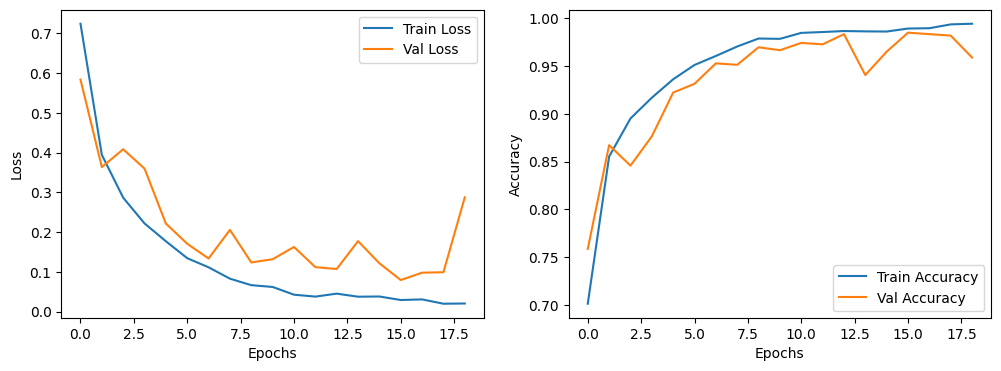

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step


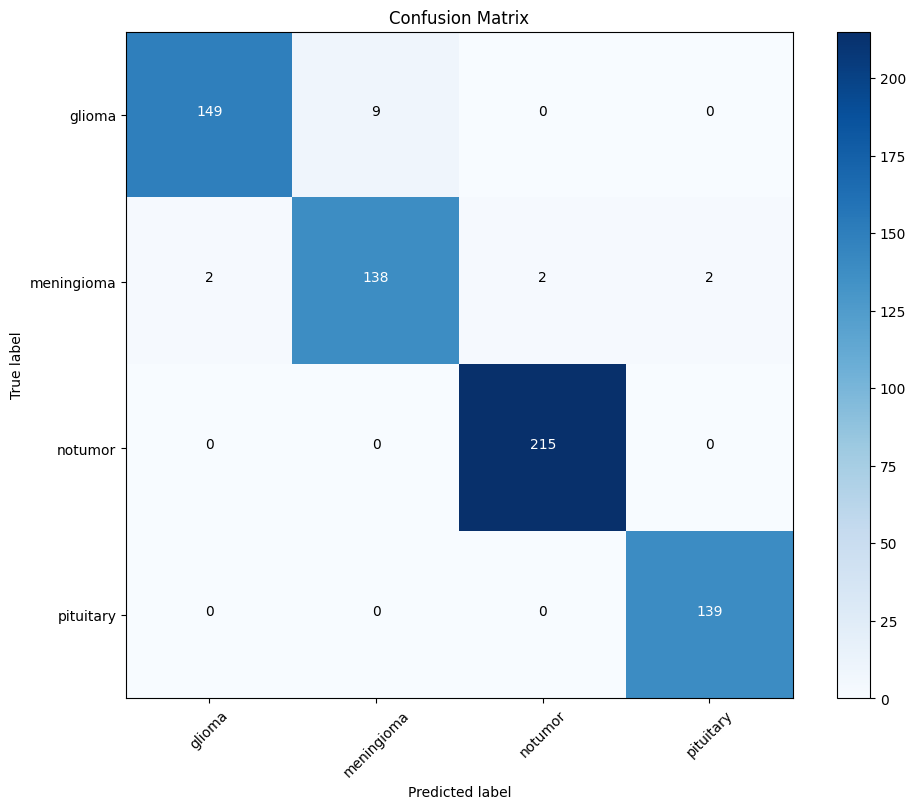

              precision    recall  f1-score   support

      glioma       0.99      0.94      0.96       158
  meningioma       0.94      0.96      0.95       144
     notumor       0.99      1.00      1.00       215
   pituitary       0.99      1.00      0.99       139

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



In [32]:
train_score = vgg_model.evaluate(train_gen)
valid_score = vgg_model.evaluate(valid_gen)
test_score = vgg_model.evaluate(test_gen)

print(f"Train Loss: {train_score[0]}, Train Accuracy: {train_score[1]}")
print(f"Validation Loss: {valid_score[0]}, Validation Accuracy: {valid_score[1]}")
print(f"Test Loss: {test_score[0]}, Test Accuracy: {test_score[1]}")

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history_vgg)

# Get predictions and generate confusion matrix and classification report
preds = vgg_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(test_gen.classes, y_pred)
class_names = list(test_gen.class_indices.keys())

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm, class_names)
print(classification_report(test_gen.classes, y_pred, target_names=class_names))


# 2. ResNet-18 for MRI Segmentation
## Building the ResNet-18 Model for Segmentation

In [25]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Input, Add, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
def resnet_block(inputs, filters, kernel_size=3, strides=1, activation='relu', batch_norm=True):
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    if batch_norm:
        x = BatchNormalization()(x)
    if activation:
        x = Activation(activation)(x)
    return x

def identity_block(inputs, filters):
    x = resnet_block(inputs, filters)
    x = resnet_block(x, filters, activation=None)
    x = Add()([x, inputs])
    x = Activation('relu')(x)
    return x

def conv_block(inputs, filters, strides=2):
    x = resnet_block(inputs, filters, strides=strides)
    x = resnet_block(x, filters, activation=None)
    shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(inputs)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x


In [27]:
def build_resnet18_classification(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial conv layer
    x = resnet_block(inputs, 64, strides=2)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = conv_block(x, 128)
    x = identity_block(x, 128)
    x = conv_block(x, 256)
    x = identity_block(x, 256)
    x = conv_block(x, 512)
    x = identity_block(x, 512)

    # Classification head
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (128, 128, 3)  # Example input shape
num_classes = 4  # Change this to the number of classes in your dataset
resnet18_classification_model = build_resnet18_classification(input_shape, num_classes)

# Print the model summary to verify the architecture
resnet18_classification_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 64, 64, 64)     │          1,792 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_45    │ (None, 64, 64, 64)     │            256 │ conv2d_53[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_45             │ (None, 64, 64, 64)     │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 32, 32, 64)     │              0 │ activation_45[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_46    │ (None, 32, 32, 64)     │            256 │ conv2d_54[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_46             │ (None, 32, 32, 64)     │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ activation_46[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_47    │ (None, 32, 32, 64)     │            256 │ conv2d_55[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 32, 32, 64)     │              0 │ batch_normalization_4… │
│                           │                        │                │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_47             │ (None, 32, 32, 64)     │              0 │ add_8[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ activation_47[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_48    │ (None, 32, 32, 64)     │            256 │ conv2d_56[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_48        

 Total params: 11,181,700 (42.65 MB)

 Trainable params: 11,173,892 (42.63 MB)

 Non-trainable params: 7,808 (30.50 KB)

In [28]:
# Use the same data generators as defined before
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = resnet18_classification_model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=[early_stopping])


Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 57s 197ms/step - accuracy: 0.6793 - loss: 0.9265 - val_accuracy: 0.2168 - val_loss: 11.5700
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.8434 - loss: 0.4193 - val_accuracy: 0.5802 - val_loss: 0.9925
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.8793 - loss: 0.3296 - val_accuracy: 0.3313 - val_loss: 2.3666
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.9112 - loss: 0.2497 - val_accuracy: 0.5618 - val_loss: 2.5456
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.9488 - loss: 0.1411 - val_accuracy: 0.9084 - val_loss: 0.2239
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.9541 - loss: 0.1234 - val_accuracy: 0.9359 - val_loss: 0.1704
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.9685 - loss: 0.0858 - val_accuracy: 0.8336 - val_loss: 0.4681
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.9620 - loss: 

## Evaluate the model

180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.9955 - loss: 0.0187
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9677 - loss: 0.0946
 1/21 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9688 - loss: 0.0452

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.9733 - loss: 0.0809
Train Loss: 0.020638713613152504, Train Accuracy: 0.9946134090423584
Validation Loss: 0.08457968384027481, Validation Accuracy: 0.9725190997123718
Test Loss: 0.07478368282318115, Test Accuracy: 0.9756097793579102


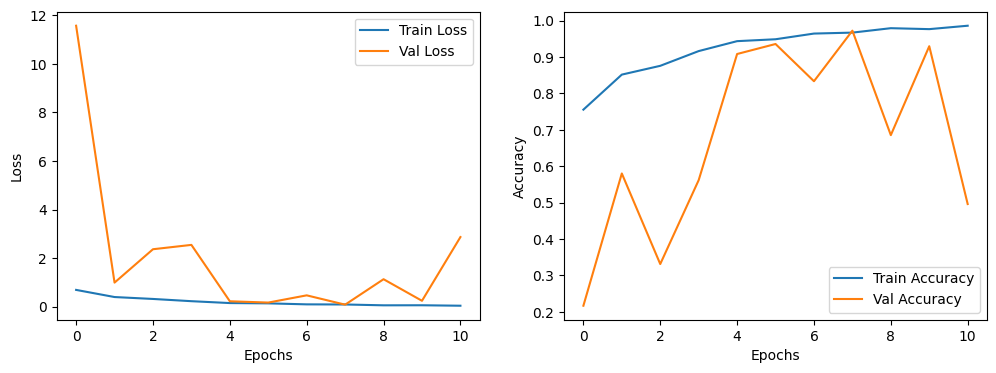

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step


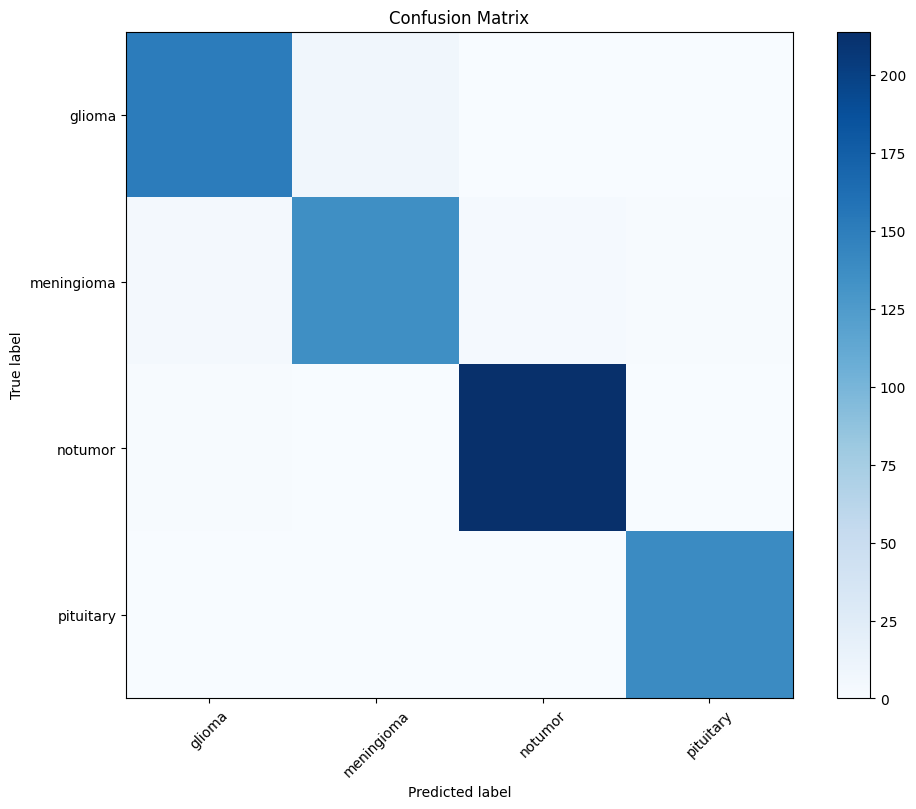

              precision    recall  f1-score   support

      glioma       0.97      0.96      0.96       158
  meningioma       0.95      0.94      0.95       144
     notumor       0.99      1.00      0.99       215
   pituitary       0.99      1.00      1.00       139

    accuracy                           0.98       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.98      0.98      0.98       656



In [30]:
train_score = resnet18_classification_model.evaluate(train_gen)
valid_score = resnet18_classification_model.evaluate(valid_gen)
test_score = resnet18_classification_model.evaluate(test_gen)

print(f"Train Loss: {train_score[0]}, Train Accuracy: {train_score[1]}")
print(f"Validation Loss: {valid_score[0]}, Validation Accuracy: {valid_score[1]}")
print(f"Test Loss: {test_score[0]}, Test Accuracy: {test_score[1]}")

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history)

# Get predictions and generate confusion matrix and classification report
preds = resnet18_classification_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(test_gen.classes, y_pred)
class_names = list(test_gen.class_indices.keys())

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0], cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm, class_names)
print(classification_report(test_gen.classes, y_pred, target_names=class_names))


# Model 3: Custom CNN with Transfer Learning from VGG16
This model uses the VGG16 pre-trained model fine-tuned on MRI images.

## Building the Custom CNN Model with VGG16

In [31]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_custom_vgg16_model(input_shape, num_classes):
    # Load the VGG16 model without the top layers (include_top=False)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    # Build the custom model on top of the VGG16 base
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Explicitly build the model by calling it on a test input
    model.build(input_shape=(None, *input_shape))

    return model

input_shape = (128, 128, 3)
num_classes = len(train_gen.class_indices)

vgg16_model = build_custom_vgg16_model(input_shape, num_classes)
vgg16_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_63               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,981,444 (57.15 MB)

 Trainable params: 265,732 (1.01 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

## Training the Custom CNN with VGG16

In [33]:
history_vgg16 = vgg16_model.fit(train_gen, epochs=25, validation_data=valid_gen, callbacks=[early_stopping])

Epoch 1/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 34s 161ms/step - accuracy: 0.5573 - loss: 1.0565 - val_accuracy: 0.7542 - val_loss: 0.8885
Epoch 2/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.8163 - loss: 0.4899 - val_accuracy: 0.8336 - val_loss: 0.5524
Epoch 3/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.8510 - loss: 0.3930 - val_accuracy: 0.8550 - val_loss: 0.4056


## Evaluate the model on training, validation, and test **sets**

180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.8029 - loss: 0.8387
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.7540 - loss: 0.9084
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.7486 - loss: 0.9036
Train Loss: 0.8394460082054138, Train Accuracy: 0.8079930543899536
Validation Loss: 0.8885295987129211, Validation Accuracy: 0.7541984915733337
Test Loss: 0.879470705986023, Test Accuracy: 0.7591463327407837


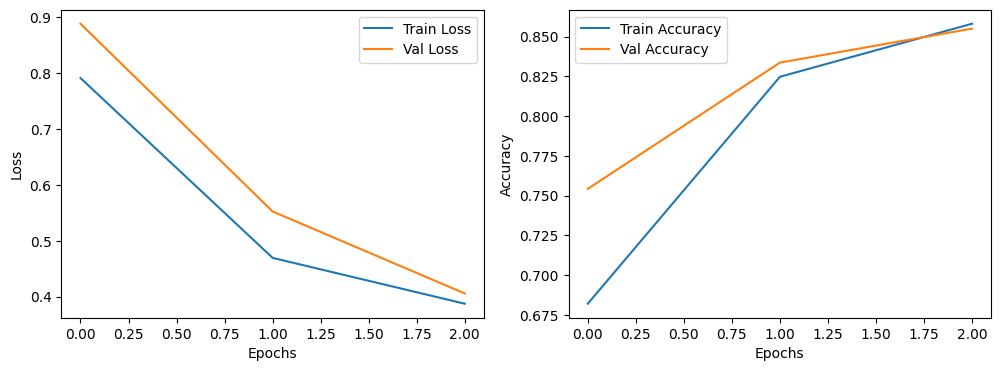

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step


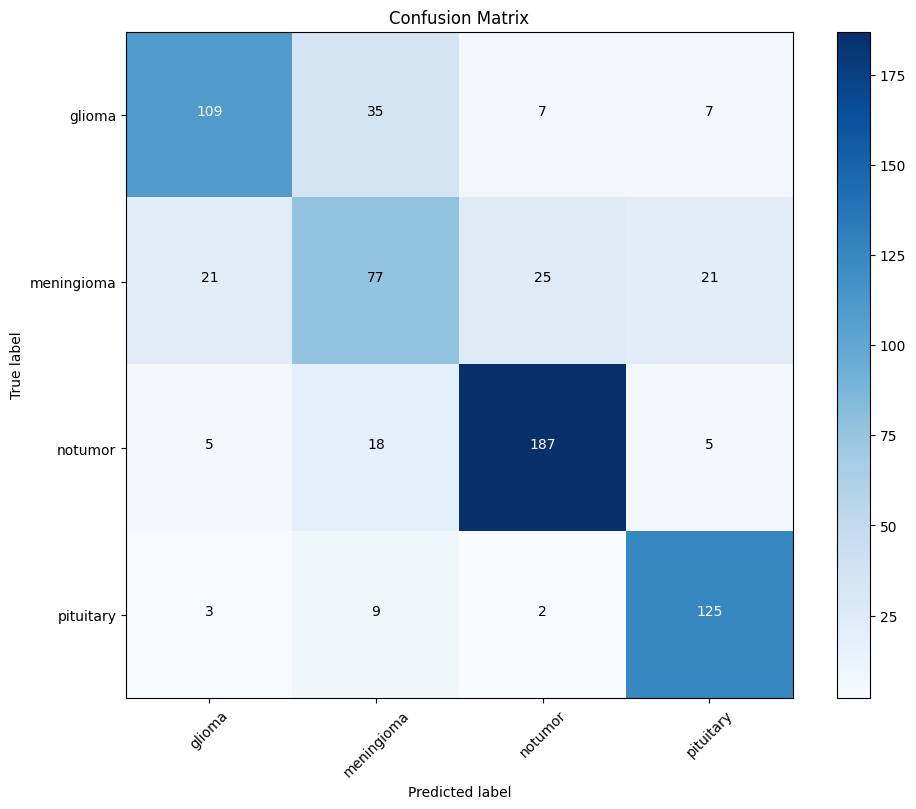

              precision    recall  f1-score   support

      glioma       0.79      0.69      0.74       158
  meningioma       0.55      0.53      0.54       144
     notumor       0.85      0.87      0.86       215
   pituitary       0.79      0.90      0.84       139

    accuracy                           0.76       656
   macro avg       0.75      0.75      0.75       656
weighted avg       0.76      0.76      0.76       656



In [34]:
train_score = vgg16_model.evaluate(train_gen)
valid_score = vgg16_model.evaluate(valid_gen)
test_score = vgg16_model.evaluate(test_gen)

print(f"Train Loss: {train_score[0]}, Train Accuracy: {train_score[1]}")
print(f"Validation Loss: {valid_score[0]}, Validation Accuracy: {valid_score[1]}")
print(f"Test Loss: {test_score[0]}, Test Accuracy: {test_score[1]}")

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history_vgg16)

# Get predictions and generate confusion matrix and classification report
preds = vgg16_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(test_gen.classes, y_pred)
class_names = list(test_gen.class_indices.keys())

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm, class_names)
print(classification_report(test_gen.classes, y_pred, target_names=class_names))


# Visualizing Sample Images with Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


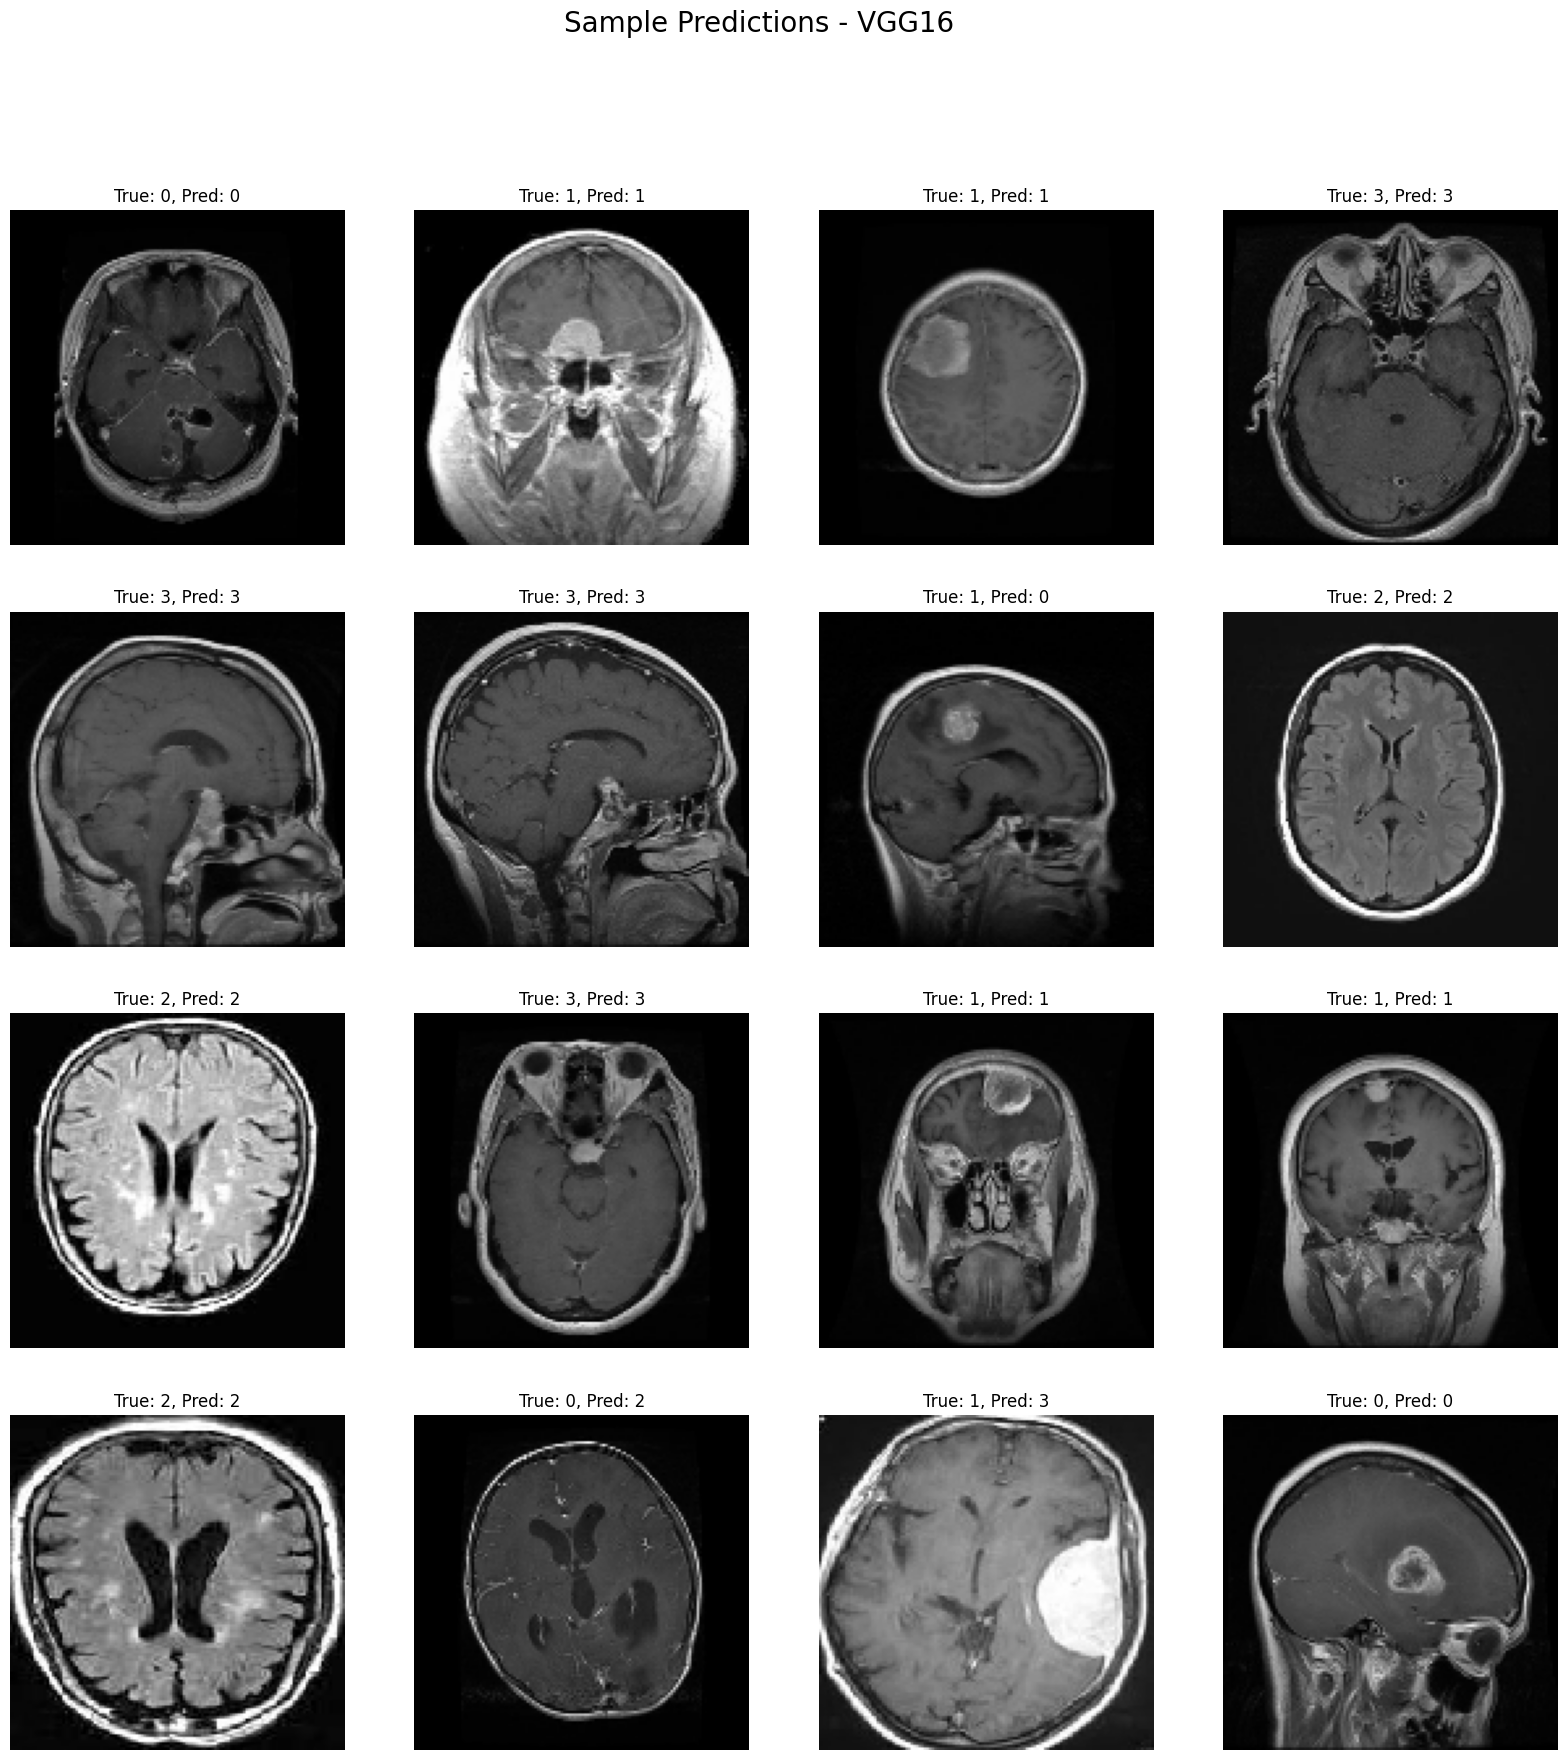

In [41]:
def plot_sample_predictions(generator, model, title):
    images, labels = next(generator)
    preds = model.predict(images)
    plt.figure(figsize=(20, 20))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        true_label = np.argmax(labels[i])
        pred_label = np.argmax(preds[i])
        plt.title(f'True: {true_label}, Pred: {pred_label}', fontsize=12)
        plt.axis('off')
    plt.suptitle(title, fontsize=20)
    plt.show()

plot_sample_predictions(test_gen, vgg16_model, "Sample Predictions - VGG16")
